# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 4202496/11490434 [=========>....................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 14:03 - loss: 0.6939

  26/1875 [..............................] - ETA: 3s - loss: 0.5652   

  55/1875 [..............................] - ETA: 3s - loss: 0.4766

  87/1875 [>.............................] - ETA: 3s - loss: 0.4275

 119/1875 [>.............................] - ETA: 3s - loss: 0.3972

 149/1875 [=>............................] - ETA: 2s - loss: 0.3772

 159/1875 [=>............................] - ETA: 3s - loss: 0.3716

 180/1875 [=>............................] - ETA: 3s - loss: 0.3611

 201/1875 [==>...........................] - ETA: 3s - loss: 0.3520

 226/1875 [==>...........................] - ETA: 3s - loss: 0.3425

 255/1875 [===>..........................] - ETA: 3s - loss: 0.3328

 284/1875 [===>..........................] - ETA: 3s - loss: 0.3244

 310/1875 [===>..........................] - ETA: 3s - loss: 0.3176

 337/1875 [====>.........................] - ETA: 3s - loss: 0.3113

 363/1875 [====>.........................] - ETA: 2s - loss: 0.3057

 388/1875 [=====>........................] - ETA: 2s - loss: 0.3008

 414/1875 [=====>........................] - ETA: 2s - loss: 0.2961

 434/1875 [=====>........................] - ETA: 2s - loss: 0.2927

 460/1875 [======>.......................] - ETA: 2s - loss: 0.2885

 480/1875 [======>.......................] - ETA: 2s - loss: 0.2855

 511/1875 [=======>......................] - ETA: 2s - loss: 0.2811

 540/1875 [=======>......................] - ETA: 2s - loss: 0.2773

 566/1875 [========>.....................] - ETA: 2s - loss: 0.2741

 592/1875 [========>.....................] - ETA: 2s - loss: 0.2710

 624/1875 [========>.....................] - ETA: 2s - loss: 0.2675

 652/1875 [=========>....................] - ETA: 2s - loss: 0.2646

 676/1875 [=========>....................] - ETA: 2s - loss: 0.2621

 698/1875 [==========>...................] - ETA: 2s - loss: 0.2600

 723/1875 [==========>...................] - ETA: 2s - loss: 0.2577

 747/1875 [==========>...................] - ETA: 2s - loss: 0.2556

 776/1875 [===========>..................] - ETA: 2s - loss: 0.2531

 805/1875 [===========>..................] - ETA: 2s - loss: 0.2508

 831/1875 [============>.................] - ETA: 2s - loss: 0.2488

 859/1875 [============>.................] - ETA: 1s - loss: 0.2467

 885/1875 [=============>................] - ETA: 1s - loss: 0.2448

 913/1875 [=============>................] - ETA: 1s - loss: 0.2428

 944/1875 [==============>...............] - ETA: 1s - loss: 0.2408

 965/1875 [==============>...............] - ETA: 1s - loss: 0.2394

 990/1875 [==============>...............] - ETA: 1s - loss: 0.2378

1018/1875 [===============>..............] - ETA: 1s - loss: 0.2361

1046/1875 [===============>..............] - ETA: 1s - loss: 0.2345

1078/1875 [================>.............] - ETA: 1s - loss: 0.2327

1106/1875 [================>.............] - ETA: 1s - loss: 0.2311

1133/1875 [=================>............] - ETA: 1s - loss: 0.2297

1164/1875 [=================>............] - ETA: 1s - loss: 0.2281

1195/1875 [==================>...........] - ETA: 1s - loss: 0.2265

1222/1875 [==================>...........] - ETA: 1s - loss: 0.2252

1243/1875 [==================>...........] - ETA: 1s - loss: 0.2242

1263/1875 [===================>..........] - ETA: 1s - loss: 0.2233

1285/1875 [===================>..........] - ETA: 1s - loss: 0.2223

1312/1875 [===================>..........] - ETA: 1s - loss: 0.2211

1338/1875 [====================>.........] - ETA: 1s - loss: 0.2200

1357/1875 [====================>.........] - ETA: 1s - loss: 0.2192

1377/1875 [=====================>........] - ETA: 0s - loss: 0.2184

1398/1875 [=====================>........] - ETA: 0s - loss: 0.2175

1420/1875 [=====================>........] - ETA: 0s - loss: 0.2166

1442/1875 [======================>.......] - ETA: 0s - loss: 0.2157

1469/1875 [======================>.......] - ETA: 0s - loss: 0.2147

1495/1875 [======================>.......] - ETA: 0s - loss: 0.2137

1521/1875 [=======================>......] - ETA: 0s - loss: 0.2128

1548/1875 [=======================>......] - ETA: 0s - loss: 0.2118

1575/1875 [========================>.....] - ETA: 0s - loss: 0.2108

1602/1875 [========================>.....] - ETA: 0s - loss: 0.2099

1629/1875 [=========================>....] - ETA: 0s - loss: 0.2090

1650/1875 [=========================>....] - ETA: 0s - loss: 0.2083

1672/1875 [=========================>....] - ETA: 0s - loss: 0.2076

1696/1875 [==========================>...] - ETA: 0s - loss: 0.2068

1717/1875 [==========================>...] - ETA: 0s - loss: 0.2061

1743/1875 [==========================>...] - ETA: 0s - loss: 0.2053

1768/1875 [===========================>..] - ETA: 0s - loss: 0.2046

1792/1875 [===========================>..] - ETA: 0s - loss: 0.2039

1817/1875 [============================>.] - ETA: 0s - loss: 0.2031

1841/1875 [============================>.] - ETA: 0s - loss: 0.2024

1864/1875 [============================>.] - ETA: 0s - loss: 0.2018

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2014


Epoch 2/5
   1/1875 [..............................] - ETA: 4s - loss: 0.1075

  26/1875 [..............................] - ETA: 3s - loss: 0.1111

  52/1875 [..............................] - ETA: 3s - loss: 0.1103

  77/1875 [>.............................] - ETA: 3s - loss: 0.1101

 103/1875 [>.............................] - ETA: 3s - loss: 0.1098

 125/1875 [=>............................] - ETA: 3s - loss: 0.1097

 150/1875 [=>............................] - ETA: 3s - loss: 0.1096

 173/1875 [=>............................] - ETA: 3s - loss: 0.1095

 198/1875 [==>...........................] - ETA: 3s - loss: 0.1094

 221/1875 [==>...........................] - ETA: 3s - loss: 0.1092

 244/1875 [==>...........................] - ETA: 3s - loss: 0.1091

 266/1875 [===>..........................] - ETA: 3s - loss: 0.1090

 289/1875 [===>..........................] - ETA: 3s - loss: 0.1090

 310/1875 [===>..........................] - ETA: 3s - loss: 0.1089

 330/1875 [====>.........................] - ETA: 3s - loss: 0.1088

 352/1875 [====>.........................] - ETA: 3s - loss: 0.1088

 378/1875 [=====>........................] - ETA: 3s - loss: 0.1087

 399/1875 [=====>........................] - ETA: 3s - loss: 0.1086

 423/1875 [=====>........................] - ETA: 3s - loss: 0.1086

 441/1875 [======>.......................] - ETA: 3s - loss: 0.1085

 465/1875 [======>.......................] - ETA: 3s - loss: 0.1084

 486/1875 [======>.......................] - ETA: 3s - loss: 0.1084

 509/1875 [=======>......................] - ETA: 3s - loss: 0.1083

 531/1875 [=======>......................] - ETA: 2s - loss: 0.1083

 554/1875 [=======>......................] - ETA: 2s - loss: 0.1082

 575/1875 [========>.....................] - ETA: 2s - loss: 0.1081

 599/1875 [========>.....................] - ETA: 2s - loss: 0.1081

 620/1875 [========>.....................] - ETA: 2s - loss: 0.1080

 641/1875 [=========>....................] - ETA: 2s - loss: 0.1080

 668/1875 [=========>....................] - ETA: 2s - loss: 0.1079

 694/1875 [==========>...................] - ETA: 2s - loss: 0.1078

 717/1875 [==========>...................] - ETA: 2s - loss: 0.1078

 744/1875 [==========>...................] - ETA: 2s - loss: 0.1077

 771/1875 [===========>..................] - ETA: 2s - loss: 0.1076

 795/1875 [===========>..................] - ETA: 2s - loss: 0.1076

 820/1875 [============>.................] - ETA: 2s - loss: 0.1075

 845/1875 [============>.................] - ETA: 2s - loss: 0.1074

 872/1875 [============>.................] - ETA: 2s - loss: 0.1074

 898/1875 [=============>................] - ETA: 2s - loss: 0.1073

 924/1875 [=============>................] - ETA: 2s - loss: 0.1072

 949/1875 [==============>...............] - ETA: 1s - loss: 0.1072

 975/1875 [==============>...............] - ETA: 1s - loss: 0.1071

1001/1875 [===============>..............] - ETA: 1s - loss: 0.1070

1028/1875 [===============>..............] - ETA: 1s - loss: 0.1070

1057/1875 [===============>..............] - ETA: 1s - loss: 0.1069

1082/1875 [================>.............] - ETA: 1s - loss: 0.1068

1105/1875 [================>.............] - ETA: 1s - loss: 0.1068

1129/1875 [=================>............] - ETA: 1s - loss: 0.1067

1153/1875 [=================>............] - ETA: 1s - loss: 0.1067

1175/1875 [=================>............] - ETA: 1s - loss: 0.1066

1198/1875 [==================>...........] - ETA: 1s - loss: 0.1066

1222/1875 [==================>...........] - ETA: 1s - loss: 0.1065

1247/1875 [==================>...........] - ETA: 1s - loss: 0.1065

1270/1875 [===================>..........] - ETA: 1s - loss: 0.1064

1292/1875 [===================>..........] - ETA: 1s - loss: 0.1064

1314/1875 [====================>.........] - ETA: 1s - loss: 0.1063

1335/1875 [====================>.........] - ETA: 1s - loss: 0.1063

1357/1875 [====================>.........] - ETA: 1s - loss: 0.1063

1380/1875 [=====================>........] - ETA: 1s - loss: 0.1062

1406/1875 [=====================>........] - ETA: 1s - loss: 0.1062

1432/1875 [=====================>........] - ETA: 0s - loss: 0.1061

1456/1875 [======================>.......] - ETA: 0s - loss: 0.1061

1482/1875 [======================>.......] - ETA: 0s - loss: 0.1060

1504/1875 [=======================>......] - ETA: 0s - loss: 0.1060

1527/1875 [=======================>......] - ETA: 0s - loss: 0.1059

1549/1875 [=======================>......] - ETA: 0s - loss: 0.1059

1568/1875 [========================>.....] - ETA: 0s - loss: 0.1058

1589/1875 [========================>.....] - ETA: 0s - loss: 0.1058

1616/1875 [========================>.....] - ETA: 0s - loss: 0.1058

1639/1875 [=========================>....] - ETA: 0s - loss: 0.1057

1663/1875 [=========================>....] - ETA: 0s - loss: 0.1057

1690/1875 [==========================>...] - ETA: 0s - loss: 0.1056

1717/1875 [==========================>...] - ETA: 0s - loss: 0.1056

1739/1875 [==========================>...] - ETA: 0s - loss: 0.1055

1764/1875 [===========================>..] - ETA: 0s - loss: 0.1055

1784/1875 [===========================>..] - ETA: 0s - loss: 0.1055

1806/1875 [===========================>..] - ETA: 0s - loss: 0.1054

1830/1875 [============================>.] - ETA: 0s - loss: 0.1054

1849/1875 [============================>.] - ETA: 0s - loss: 0.1054

1869/1875 [============================>.] - ETA: 0s - loss: 0.1053

1875/1875 [==============================] - 4s 2ms/step - loss: 0.1053


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1039

  28/1875 [..............................] - ETA: 3s - loss: 0.0996

  53/1875 [..............................] - ETA: 3s - loss: 0.0991

  77/1875 [>.............................] - ETA: 3s - loss: 0.0990

 103/1875 [>.............................] - ETA: 3s - loss: 0.0989

 130/1875 [=>............................] - ETA: 3s - loss: 0.0988

 157/1875 [=>............................] - ETA: 3s - loss: 0.0987

 184/1875 [=>............................] - ETA: 3s - loss: 0.0986

 211/1875 [==>...........................] - ETA: 3s - loss: 0.0986

 238/1875 [==>...........................] - ETA: 3s - loss: 0.0985

 265/1875 [===>..........................] - ETA: 3s - loss: 0.0984

 292/1875 [===>..........................] - ETA: 3s - loss: 0.0984

 319/1875 [====>.........................] - ETA: 2s - loss: 0.0983

 342/1875 [====>.........................] - ETA: 2s - loss: 0.0982

 364/1875 [====>.........................] - ETA: 2s - loss: 0.0982

 382/1875 [=====>........................] - ETA: 3s - loss: 0.0982

 405/1875 [=====>........................] - ETA: 2s - loss: 0.0981

 427/1875 [=====>........................] - ETA: 2s - loss: 0.0981

 453/1875 [======>.......................] - ETA: 2s - loss: 0.0981

 475/1875 [======>.......................] - ETA: 2s - loss: 0.0980

 497/1875 [======>.......................] - ETA: 2s - loss: 0.0980

 518/1875 [=======>......................] - ETA: 2s - loss: 0.0980

 539/1875 [=======>......................] - ETA: 2s - loss: 0.0980

 559/1875 [=======>......................] - ETA: 2s - loss: 0.0980

 582/1875 [========>.....................] - ETA: 2s - loss: 0.0979

 601/1875 [========>.....................] - ETA: 2s - loss: 0.0979

 620/1875 [========>.....................] - ETA: 2s - loss: 0.0979

 641/1875 [=========>....................] - ETA: 2s - loss: 0.0979

 667/1875 [=========>....................] - ETA: 2s - loss: 0.0979

 692/1875 [==========>...................] - ETA: 2s - loss: 0.0979

 719/1875 [==========>...................] - ETA: 2s - loss: 0.0979

 746/1875 [==========>...................] - ETA: 2s - loss: 0.0978

 769/1875 [===========>..................] - ETA: 2s - loss: 0.0978

 791/1875 [===========>..................] - ETA: 2s - loss: 0.0978

 810/1875 [===========>..................] - ETA: 2s - loss: 0.0978

 830/1875 [============>.................] - ETA: 2s - loss: 0.0978

 853/1875 [============>.................] - ETA: 2s - loss: 0.0978

 878/1875 [=============>................] - ETA: 2s - loss: 0.0978

 905/1875 [=============>................] - ETA: 2s - loss: 0.0978

 927/1875 [=============>................] - ETA: 2s - loss: 0.0978

 950/1875 [==============>...............] - ETA: 1s - loss: 0.0978

 970/1875 [==============>...............] - ETA: 1s - loss: 0.0978

 995/1875 [==============>...............] - ETA: 1s - loss: 0.0978

1021/1875 [===============>..............] - ETA: 1s - loss: 0.0977

1043/1875 [===============>..............] - ETA: 1s - loss: 0.0977

1068/1875 [================>.............] - ETA: 1s - loss: 0.0977

1094/1875 [================>.............] - ETA: 1s - loss: 0.0977

1119/1875 [================>.............] - ETA: 1s - loss: 0.0977

1142/1875 [=================>............] - ETA: 1s - loss: 0.0977

1157/1875 [=================>............] - ETA: 1s - loss: 0.0977

1183/1875 [=================>............] - ETA: 1s - loss: 0.0977

1208/1875 [==================>...........] - ETA: 1s - loss: 0.0977

1233/1875 [==================>...........] - ETA: 1s - loss: 0.0977

1257/1875 [===================>..........] - ETA: 1s - loss: 0.0977

1283/1875 [===================>..........] - ETA: 1s - loss: 0.0977

1308/1875 [===================>..........] - ETA: 1s - loss: 0.0977

1334/1875 [====================>.........] - ETA: 1s - loss: 0.0976

1359/1875 [====================>.........] - ETA: 1s - loss: 0.0976

1385/1875 [=====================>........] - ETA: 1s - loss: 0.0976

1410/1875 [=====================>........] - ETA: 0s - loss: 0.0976

1436/1875 [=====================>........] - ETA: 0s - loss: 0.0976

1461/1875 [======================>.......] - ETA: 0s - loss: 0.0976

1486/1875 [======================>.......] - ETA: 0s - loss: 0.0976

1511/1875 [=======================>......] - ETA: 0s - loss: 0.0976

1535/1875 [=======================>......] - ETA: 0s - loss: 0.0976

1561/1875 [=======================>......] - ETA: 0s - loss: 0.0976

1586/1875 [========================>.....] - ETA: 0s - loss: 0.0976

1612/1875 [========================>.....] - ETA: 0s - loss: 0.0976

1639/1875 [=========================>....] - ETA: 0s - loss: 0.0975

1661/1875 [=========================>....] - ETA: 0s - loss: 0.0975

1687/1875 [=========================>....] - ETA: 0s - loss: 0.0975

1714/1875 [==========================>...] - ETA: 0s - loss: 0.0975

1740/1875 [==========================>...] - ETA: 0s - loss: 0.0975

1767/1875 [===========================>..] - ETA: 0s - loss: 0.0975

1794/1875 [===========================>..] - ETA: 0s - loss: 0.0975

1821/1875 [============================>.] - ETA: 0s - loss: 0.0975

1848/1875 [============================>.] - ETA: 0s - loss: 0.0975

1874/1875 [============================>.] - ETA: 0s - loss: 0.0975

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0975


Epoch 4/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0918

  27/1875 [..............................] - ETA: 3s - loss: 0.0948

  53/1875 [..............................] - ETA: 3s - loss: 0.0951

  75/1875 [>.............................] - ETA: 3s - loss: 0.0951

 100/1875 [>.............................] - ETA: 3s - loss: 0.0952

 125/1875 [=>............................] - ETA: 3s - loss: 0.0953

 145/1875 [=>............................] - ETA: 3s - loss: 0.0953

 167/1875 [=>............................] - ETA: 3s - loss: 0.0953

 192/1875 [==>...........................] - ETA: 3s - loss: 0.0954

 217/1875 [==>...........................] - ETA: 3s - loss: 0.0954

 242/1875 [==>...........................] - ETA: 3s - loss: 0.0954

 267/1875 [===>..........................] - ETA: 3s - loss: 0.0955

 292/1875 [===>..........................] - ETA: 3s - loss: 0.0955

 318/1875 [====>.........................] - ETA: 3s - loss: 0.0955

 344/1875 [====>.........................] - ETA: 3s - loss: 0.0955

 370/1875 [====>.........................] - ETA: 3s - loss: 0.0955

 396/1875 [=====>........................] - ETA: 3s - loss: 0.0954

 422/1875 [=====>........................] - ETA: 3s - loss: 0.0954

 447/1875 [======>.......................] - ETA: 2s - loss: 0.0954

 472/1875 [======>.......................] - ETA: 2s - loss: 0.0954

 498/1875 [======>.......................] - ETA: 2s - loss: 0.0954

 524/1875 [=======>......................] - ETA: 2s - loss: 0.0954

 550/1875 [=======>......................] - ETA: 2s - loss: 0.0954

 576/1875 [========>.....................] - ETA: 2s - loss: 0.0954

 602/1875 [========>.....................] - ETA: 2s - loss: 0.0954

 627/1875 [=========>....................] - ETA: 2s - loss: 0.0954

 653/1875 [=========>....................] - ETA: 2s - loss: 0.0954

 679/1875 [=========>....................] - ETA: 2s - loss: 0.0954

 705/1875 [==========>...................] - ETA: 2s - loss: 0.0954

 731/1875 [==========>...................] - ETA: 2s - loss: 0.0954

 758/1875 [===========>..................] - ETA: 2s - loss: 0.0954

 780/1875 [===========>..................] - ETA: 2s - loss: 0.0954

 806/1875 [===========>..................] - ETA: 2s - loss: 0.0954

 829/1875 [============>.................] - ETA: 2s - loss: 0.0954

 848/1875 [============>.................] - ETA: 2s - loss: 0.0954

 872/1875 [============>.................] - ETA: 2s - loss: 0.0954

 897/1875 [=============>................] - ETA: 2s - loss: 0.0954

 923/1875 [=============>................] - ETA: 1s - loss: 0.0955

 947/1875 [==============>...............] - ETA: 1s - loss: 0.0955

 971/1875 [==============>...............] - ETA: 1s - loss: 0.0955

 996/1875 [==============>...............] - ETA: 1s - loss: 0.0955

1020/1875 [===============>..............] - ETA: 1s - loss: 0.0955

1045/1875 [===============>..............] - ETA: 1s - loss: 0.0955

1070/1875 [================>.............] - ETA: 1s - loss: 0.0955

1095/1875 [================>.............] - ETA: 1s - loss: 0.0955

1121/1875 [================>.............] - ETA: 1s - loss: 0.0955

1147/1875 [=================>............] - ETA: 1s - loss: 0.0955

1174/1875 [=================>............] - ETA: 1s - loss: 0.0955

1200/1875 [==================>...........] - ETA: 1s - loss: 0.0955

1225/1875 [==================>...........] - ETA: 1s - loss: 0.0955

1252/1875 [===================>..........] - ETA: 1s - loss: 0.0955

1278/1875 [===================>..........] - ETA: 1s - loss: 0.0955

1304/1875 [===================>..........] - ETA: 1s - loss: 0.0955

1331/1875 [====================>.........] - ETA: 1s - loss: 0.0955

1358/1875 [====================>.........] - ETA: 1s - loss: 0.0955

1384/1875 [=====================>........] - ETA: 0s - loss: 0.0955

1411/1875 [=====================>........] - ETA: 0s - loss: 0.0955

1438/1875 [======================>.......] - ETA: 0s - loss: 0.0955

1464/1875 [======================>.......] - ETA: 0s - loss: 0.0955

1490/1875 [======================>.......] - ETA: 0s - loss: 0.0955

1517/1875 [=======================>......] - ETA: 0s - loss: 0.0955

1543/1875 [=======================>......] - ETA: 0s - loss: 0.0955

1569/1875 [========================>.....] - ETA: 0s - loss: 0.0955

1596/1875 [========================>.....] - ETA: 0s - loss: 0.0955

1623/1875 [========================>.....] - ETA: 0s - loss: 0.0955

1649/1875 [=========================>....] - ETA: 0s - loss: 0.0955

1676/1875 [=========================>....] - ETA: 0s - loss: 0.0955

1703/1875 [==========================>...] - ETA: 0s - loss: 0.0955

1729/1875 [==========================>...] - ETA: 0s - loss: 0.0955

1756/1875 [===========================>..] - ETA: 0s - loss: 0.0955

1781/1875 [===========================>..] - ETA: 0s - loss: 0.0955

1803/1875 [===========================>..] - ETA: 0s - loss: 0.0955

1829/1875 [============================>.] - ETA: 0s - loss: 0.0955

1855/1875 [============================>.] - ETA: 0s - loss: 0.0955

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0955


Epoch 5/5


   1/1875 [..............................] - ETA: 5s - loss: 0.0994

  27/1875 [..............................] - ETA: 3s - loss: 0.0947

  53/1875 [..............................] - ETA: 3s - loss: 0.0947

  79/1875 [>.............................] - ETA: 3s - loss: 0.0947

 104/1875 [>.............................] - ETA: 3s - loss: 0.0947

 131/1875 [=>............................] - ETA: 3s - loss: 0.0947

 156/1875 [=>............................] - ETA: 3s - loss: 0.0946

 181/1875 [=>............................] - ETA: 3s - loss: 0.0946

 207/1875 [==>...........................] - ETA: 3s - loss: 0.0947

 233/1875 [==>...........................] - ETA: 3s - loss: 0.0947

 256/1875 [===>..........................] - ETA: 3s - loss: 0.0947

 281/1875 [===>..........................] - ETA: 3s - loss: 0.0947

 304/1875 [===>..........................] - ETA: 3s - loss: 0.0947

 328/1875 [====>.........................] - ETA: 3s - loss: 0.0947

 350/1875 [====>.........................] - ETA: 3s - loss: 0.0948

 373/1875 [====>.........................] - ETA: 3s - loss: 0.0948

 397/1875 [=====>........................] - ETA: 3s - loss: 0.0948

 416/1875 [=====>........................] - ETA: 3s - loss: 0.0948

 440/1875 [======>.......................] - ETA: 2s - loss: 0.0948

 465/1875 [======>.......................] - ETA: 2s - loss: 0.0948

 485/1875 [======>.......................] - ETA: 2s - loss: 0.0948

 509/1875 [=======>......................] - ETA: 2s - loss: 0.0948

 535/1875 [=======>......................] - ETA: 2s - loss: 0.0948

 556/1875 [=======>......................] - ETA: 2s - loss: 0.0948

 582/1875 [========>.....................] - ETA: 2s - loss: 0.0948

 606/1875 [========>.....................] - ETA: 2s - loss: 0.0948

 628/1875 [=========>....................] - ETA: 2s - loss: 0.0949

 654/1875 [=========>....................] - ETA: 2s - loss: 0.0949

 678/1875 [=========>....................] - ETA: 2s - loss: 0.0949

 704/1875 [==========>...................] - ETA: 2s - loss: 0.0949

 726/1875 [==========>...................] - ETA: 2s - loss: 0.0949

 746/1875 [==========>...................] - ETA: 2s - loss: 0.0949

 773/1875 [===========>..................] - ETA: 2s - loss: 0.0949

 799/1875 [===========>..................] - ETA: 2s - loss: 0.0949

 818/1875 [============>.................] - ETA: 2s - loss: 0.0949

 834/1875 [============>.................] - ETA: 2s - loss: 0.0949

 857/1875 [============>.................] - ETA: 2s - loss: 0.0949

 884/1875 [=============>................] - ETA: 2s - loss: 0.0949

 910/1875 [=============>................] - ETA: 2s - loss: 0.0949

 932/1875 [=============>................] - ETA: 2s - loss: 0.0949

 954/1875 [==============>...............] - ETA: 1s - loss: 0.0949

 977/1875 [==============>...............] - ETA: 1s - loss: 0.0949

1001/1875 [===============>..............] - ETA: 1s - loss: 0.0949

1019/1875 [===============>..............] - ETA: 1s - loss: 0.0950

1043/1875 [===============>..............] - ETA: 1s - loss: 0.0950

1063/1875 [================>.............] - ETA: 1s - loss: 0.0950

1088/1875 [================>.............] - ETA: 1s - loss: 0.0950

1112/1875 [================>.............] - ETA: 1s - loss: 0.0950

1139/1875 [=================>............] - ETA: 1s - loss: 0.0950

1164/1875 [=================>............] - ETA: 1s - loss: 0.0950

1191/1875 [==================>...........] - ETA: 1s - loss: 0.0950

1217/1875 [==================>...........] - ETA: 1s - loss: 0.0950

1244/1875 [==================>...........] - ETA: 1s - loss: 0.0950

1269/1875 [===================>..........] - ETA: 1s - loss: 0.0950

1292/1875 [===================>..........] - ETA: 1s - loss: 0.0950

1319/1875 [====================>.........] - ETA: 1s - loss: 0.0950

1345/1875 [====================>.........] - ETA: 1s - loss: 0.0950

1371/1875 [====================>.........] - ETA: 1s - loss: 0.0950

1397/1875 [=====================>........] - ETA: 1s - loss: 0.0950

1424/1875 [=====================>........] - ETA: 0s - loss: 0.0950

1450/1875 [======================>.......] - ETA: 0s - loss: 0.0950

1476/1875 [======================>.......] - ETA: 0s - loss: 0.0950

1504/1875 [=======================>......] - ETA: 0s - loss: 0.0950

1526/1875 [=======================>......] - ETA: 0s - loss: 0.0950

1547/1875 [=======================>......] - ETA: 0s - loss: 0.0950

1572/1875 [========================>.....] - ETA: 0s - loss: 0.0950

1598/1875 [========================>.....] - ETA: 0s - loss: 0.0950

1623/1875 [========================>.....] - ETA: 0s - loss: 0.0950

1648/1875 [=========================>....] - ETA: 0s - loss: 0.0950

1673/1875 [=========================>....] - ETA: 0s - loss: 0.0950

1696/1875 [==========================>...] - ETA: 0s - loss: 0.0950

1724/1875 [==========================>...] - ETA: 0s - loss: 0.0950

1749/1875 [==========================>...] - ETA: 0s - loss: 0.0950

1773/1875 [===========================>..] - ETA: 0s - loss: 0.0950

1798/1875 [===========================>..] - ETA: 0s - loss: 0.0950

1823/1875 [============================>.] - ETA: 0s - loss: 0.0950

1847/1875 [============================>.] - ETA: 0s - loss: 0.0950

1873/1875 [============================>.] - ETA: 0s - loss: 0.0950

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0950


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

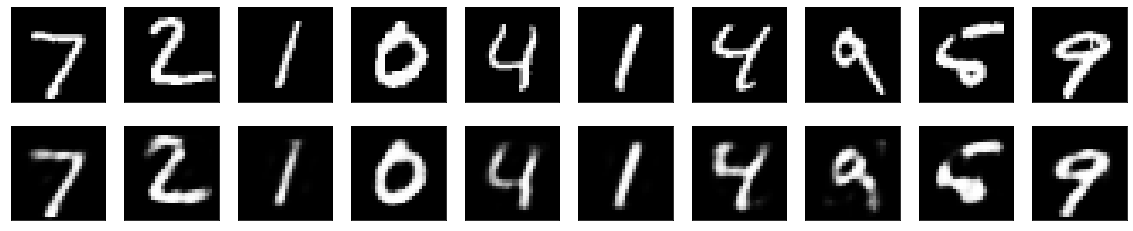

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
